In [45]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pylab as pl
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import requests
#from lxml import html
import pandas as pd
from pandas.compat import StringIO

url = "http://fuadlatip.com/uitmenergy/fyp2sept2018.php?lokasi=TOWER2&sort=DESC&dformat=normal"
response = requests.get(url)
CleanedCon = response.text.replace( '<br>',',')

Df = pd.read_csv(StringIO(CleanedCon),sep=',')
Df = Df.transpose()
MulDf = Df.index.str.split(expand=True)
Output=MulDf.to_frame(index=False)
Output.columns = Output.iloc[0]
Output = Output[1:]
DateColumn = Output["TIME"]
Output = Output.drop('TIME',axis=1)
Output.columns = ['HOURS','KW','kVar']
HourColumn = Output["HOURS"]
Output.to_csv('UrlData.csv',index=False)

# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix
        
# random seed
np.random.seed(1234)

# load the data
path_to_dataset = 'UrlData.csv'
sequence_length = 20

# vector to store the time series
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[2]))

# convert the vector to a 2D matrix
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

# shift all data by mean
matrix_vix = np.array(matrix_vix)
shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value
print ("Data  shape: ", matrix_vix.shape)

('Data  shape: ', (20710, 20))


In [46]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# build the model,initialises the network. It creates an empty "template model".
model = Sequential()
model.add(LSTM( input_dim=1, output_dim=1000, return_sequences=True))
model.add(Dropout(0.2))#"drops-out" a neuron. The 0.2 represents a percentage, it means 20% of the neurons will be "dropped" or set to 0
model.add(LSTM(output_dim=500, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1, activation='linear'))
model.compile(loss="mse", optimizer="rmsprop")
model.fit(X_train, y_train, batch_size=128, nb_epoch=50, validation_split=0.01, verbose=1)

# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

test_result = pd.DataFrame(predicted_values,columns=["predicted_values"])
test_result["y_test"] = y_test
test_result.to_csv("output_result.csv",index=False)




/home/ANANT/ajadhav/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/ANANT/ajadhav/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1000, return_sequences=True, input_shape=(None, 1))`
/home/ANANT/ajadhav/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=500, return_sequences=False)`
/home/ANANT/ajadhav/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="linear")`


Train on 18452 samples, validate on 187 samples
Epoch 1/50
18452/18452 [==============================] - 9s 509us/step - loss: 165.9290 - val_loss: 15.5144
Epoch 2/50
18452/18452 [==============================] - 9s 473us/step - loss: 17.4936 - val_loss: 10.8605
Epoch 3/50
18452/18452 [==============================] - 9s 513us/step - loss: 11.5828 - val_loss: 9.6178
Epoch 4/50
18452/18452 [==============================] - 8s 457us/step - loss: 9.7409 - val_loss: 12.3062
Epoch 5/50
18452/18452 [==============================] - 9s 468us/step - loss: 9.0276 - val_loss: 10.5242
Epoch 6/50
18452/18452 [==============================] - 9s 470us/step - loss: 8.2724 - val_loss: 7.3704
Epoch 7/50
18452/18452 [==============================] - 9s 471us/step - loss: 7.9554 - val_loss: 7.9054
Epoch 8/50
18452/18452 [==============================] - 9s 471us/step - loss: 7.5902 - val_loss: 15.0957
Epoch 9/50
18452/18452 [==============================] - 9s 470us/step - loss: 7.1439 - val_lo

In [47]:
#matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

# shift all data by mean

matrix_vix = np.array(vector_vix)
#shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value

PredictedAll = model.predict(np.reshape(matrix_vix, (pd.DataFrame(vector_vix).shape[0], pd.DataFrame(vector_vix).shape[1], 1)))
TestDf = pd.DataFrame(vector_vix, index=pd.to_datetime(DateColumn + ' ' + HourColumn), columns=['Actual'])
PredictedAll+=shifted_value
TestDf["Predicted"] = PredictedAll


<Figure size 432x288 with 0 Axes>

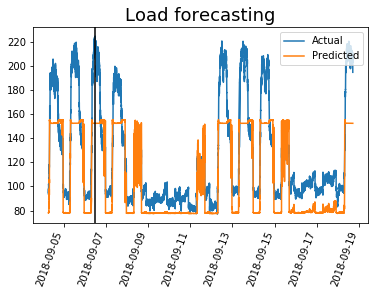

In [48]:
fig = plt.figure(); TestDf.plot(); plt.legend(loc='best');plt.xticks(rotation=70)
plt.axvline(x=TestDf.index[TestDf.Actual==max(TestDf.Actual)], color='k', linestyle='-')
plt.title('Load forecasting', fontsize=18)
plt.savefig('output_prediction.png', bbox_inches='tight')